# KE5006 Applied Research

### Identifying enhancers and their strength with deep neural networks

# Preliminary Layer 1 Model

## Summary of Findings
* Base model of 1x8 LSTM, batch size 128
	* Overfits with a maximum validation accuracy of 75.71% at epoch 2132 on 2:1 split
* Base model of 1x16 LSTM, batch size 128
	* Overfits with a maximum validation accuracy of 75.71% at epoch 1669 on 2:1 split
* Base model of 2x16 LSTM, batch size 128
	* Overfits with a maximum validation accuracy of 75.41% at epoch 477 on 2:1 split

## Load libraries

In [1]:
# Set the working directory (which contains the directories source, data, etc.)
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5006-AppliedResearch', 'enhancer'))
os.getcwd()

'/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer'

In [2]:
# Check if the directory containing the source files are in the path.
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer/source',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pickle

import myUtilities as mu

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer, recall_score, roc_auc_score, roc_curve 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate


from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Load data

In [4]:
enhancer_df = pd.read_csv(os.path.join('data', 'enhancer.csv'))
enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [5]:
enhancer_df['enhancer'] = np.ones((len(enhancer_df),))

In [6]:
enhancer_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


In [7]:
non_enhancer_df = pd.read_csv(os.path.join('data', 'non_enhancer.csv'))
non_enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [8]:
non_enhancer_df['enhancer'] = np.zeros((len(non_enhancer_df),))

In [9]:
non_enhancer_df.head()

,id,sequence,enhancer
0,CHRX_2970600_2970800,CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGG...,0.0
1,CHRX_6179400_6179600,ACTTTGAAGAAGTCAGTCATCAAGATGAGAGACCCAACTGTCAAGC...,0.0
2,CHRX_11003079_11003279,TCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCTACTGCACCC...,0.0
3,CHRX_22042679_22042879,TGGGAGCTGTATCAATCATGTTTTTTATTTTCTATATTTTATGATG...,0.0
4,CHRX_23280479_23280679,TACAGCAAATAGCCTTGGCAGATACAGTGTTTCCCTCCAGAGCAAA...,0.0


## Combine the data frames to form a single dataset

In [10]:
all_data_df = pd.concat([enhancer_df, non_enhancer_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 3 columns):
id          2968 non-null object
sequence    2968 non-null object
enhancer    2968 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.6+ KB


In [11]:
all_data_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


All the sequences are of length 200 characters.

In [12]:
all_data_df['sequence'].map(lambda x: len(x)).value_counts()

200    2968
Name: sequence, dtype: int64

## Prepare the sequence data for modelling

Initialise the keras tokenizer

In [13]:
tokenizer =  Tokenizer(num_words=4, lower=False, char_level=True)

In [14]:
tokenizer.fit_on_texts(all_data_df['sequence'][0])

In [15]:
tokenizer.word_index

{'G': 1, 'T': 2, 'A': 3, 'C': 4}

In [16]:
tokenizer.index_word

{1: 'G', 2: 'T', 3: 'A', 4: 'C'}

Test the tokenizer on the first sequence

In [17]:
all_data_df['sequence'][0][:10]

'CACAATGTAG'

In [18]:
tokenizer.texts_to_matrix(all_data_df['sequence'][0], mode='binary')[:10]

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

Create a transformation pipleline to prepare the training dataset for RNN.

In [19]:
# This class selects the desired attributes and drops the rest.
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [20]:
# This class converts a nucleotide base (A, C, G, T) to one-hot-encoding.
class one_hot_encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.tokenizer = Tokenizer(num_words=4, lower=False, char_level=True)

    def fit(self, X, y=None):
        # Note that X is a data frame.
        # Fit the tokenizer on the 1st sequence in the dataset.
        self.tokenizer.fit_on_texts(X.iloc[0, 0])
        self.len_sequence = len(X.iloc[0, 0])
        return self

    def transform(self, X):
        # Note that X is a data frame.
        one_hot_X = X.iloc[:, 0].map(lambda x: tokenizer.texts_to_matrix(x, mode='binary')).values
        one_hot_X = np.concatenate(one_hot_X)
        one_hot_X = np.reshape(one_hot_X, (-1, self.len_sequence, 4))
        return one_hot_X

In [21]:
attrbs = ['sequence']
my_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('one_hot_encoder', one_hot_encoder())
])

In [22]:
X = my_pipeline.fit_transform(all_data_df)
X.shape

(2968, 200, 4)

Check the 1st sequence is correctly encoded.

In [23]:
X[0, :10, :]

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [24]:
y = all_data_df['enhancer'].values
y.shape

(2968,)

In [25]:
y[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Split the dataset into train / validation sets

For the initial base model, we will use a simple train / validation split. 5-fold cross-validation will be used during model fine-tuning to obtain the final model.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=123)

In [27]:
X_train.shape

(1988, 200, 4)

In [28]:
X_train[0][:10]

array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [29]:
y_train.shape

(1988,)

In [30]:
y_train[0]

1.0

## Train a base RNN model

In this training phase, the aim is to find a base model with statistical power which overfits. Interatively, this base model will be scaled up first to overfit, to be followed by regularization, to improve the validation accuracy.

In the next phase, cross-validation will be applied to obtain better estimates of validation accuracy. Grid-search can be applied to fine-tune the parameters, hyper-parameters to further improve the validation accuracy.

### 1x8 LSTM

### 1x16 LSTM

In [32]:
model = Sequential()
model.add(layers.CuDNNLSTM(8, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [33]:
histories = [] # for first training session

In [34]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=4000, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-15 22:10:48.354862



Training Duration = 0:08:55.049568


In [35]:
histories.append(history.history)

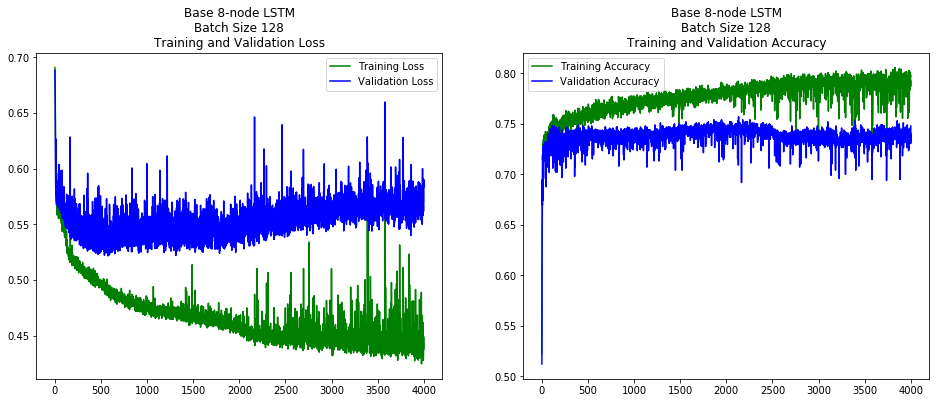

In [39]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_acc in h['acc']:
        train_acc.append(a_acc)
    for a_acc in h['val_acc']:
        val_acc.append(a_acc)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 8-node LSTM\nBatch Size 128\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 8-node LSTM\nBatch Size 128\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [40]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  576
validation accuracy =  75.71% at epoch = 2132


### 1x16 LSTM

In [31]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [32]:
model = Sequential()
model.add(layers.CuDNNLSTM(16, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [33]:
histories = [] # for first training session

In [34]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=4000, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-15 22:41:08.086593



Training Duration = 0:09:04.378086


In [35]:
histories.append(history.history)

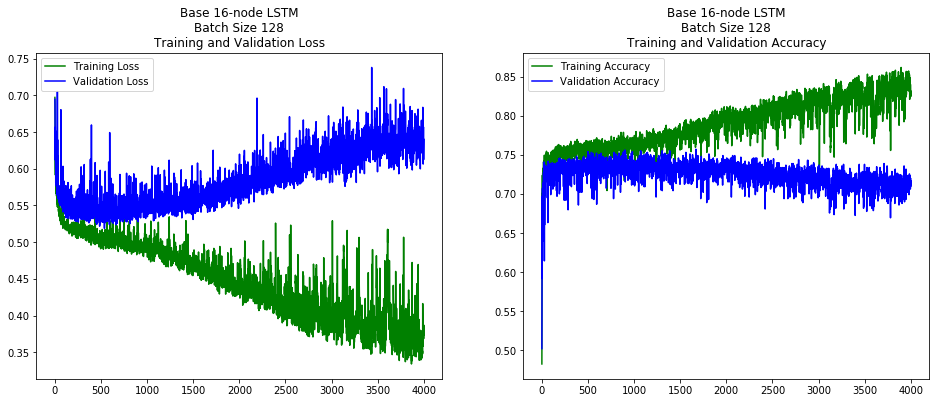

In [36]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_acc in h['acc']:
        train_acc.append(a_acc)
    for a_acc in h['val_acc']:
        val_acc.append(a_acc)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 16-node LSTM\nBatch Size 128\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 16-node LSTM\nBatch Size 128\nTraining and Validation Accuracy')
plt.legend()
plt.show()

The model overfits before ~20 training epochs. Maximum validation accuracy on this simple base model is **75.71**%, achieved at epoch 1669.

In [37]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  537
validation accuracy =  75.71% at epoch = 1669


### 2x16 LSTM

In [31]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [32]:
model = Sequential()
model.add(layers.CuDNNLSTM(16, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.CuDNNLSTM(16))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [33]:
histories = [] # for first training session

In [34]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=4000, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-15 23:17:25.133005



Training Duration = 0:15:28.544378


In [35]:
histories.append(history.history)

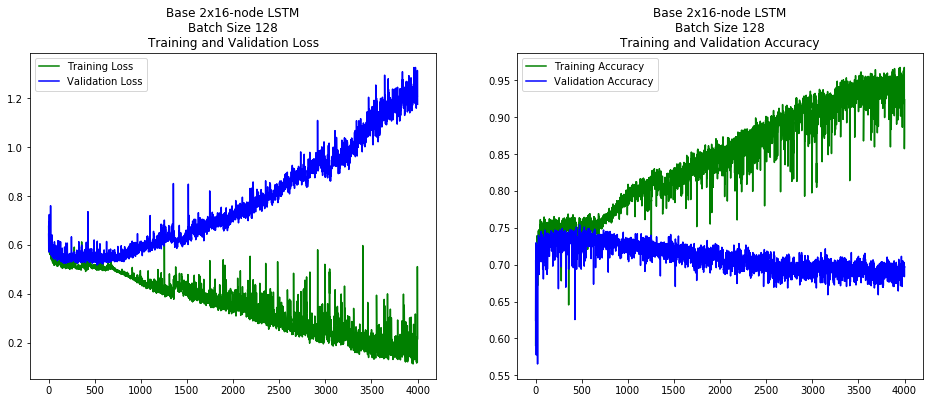

In [36]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_acc in h['acc']:
        train_acc.append(a_acc)
    for a_acc in h['val_acc']:
        val_acc.append(a_acc)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2x16-node LSTM\nBatch Size 128\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 2x16-node LSTM\nBatch Size 128\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [37]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  525
validation accuracy =  75.41% at epoch =  477


# ============ TO BE EDITED =============

### Apply regularization to the base model to reduce overfitting / achieve a higher accuracy

### Apply dropouts

In [31]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [33]:
model = Sequential()
model.add(layers.GRU(16, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 16)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-1x16gru-dropout0202-histories-epch3000.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-1x16gru-dropout0202-epch3000.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 16)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


In [41]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=500, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-10 23:40:00.126197



Training Duration = 0:16:33.847830


In [42]:
# histories = []  # only for first training session
histories.append(history.history)

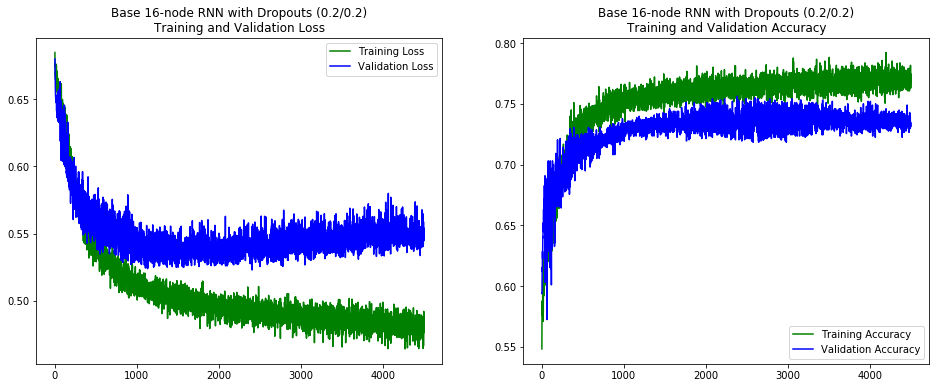

In [43]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_acc in history['acc']:
        train_acc.append(a_acc)
    for a_val_acc in history['val_acc']:
        val_acc.append(a_val_acc)

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 16-node RNN with Dropouts (0.2/0.2)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 16-node RNN with Dropouts (0.2/0.2)\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [44]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch = 2406
validation accuracy =  75.61% at epoch = 2383


In [45]:
with open(os.path.join('models', 'base-1x16gru-dropout0202-histories.pkl'), 'wb') as outfile:
    pickle.dump(histories, outfile)

In [46]:
model.save(os.path.join('models', 'base-1x16gru-dropout0202.h5'))